## Q(a)
Use the best model you have from Mini-project #3, and play with different activation
functions in different layers. You may use different activations in different layers. What can you find?
Report the best model you can obtain that yields highest accuracy (lowest MSE). Plot the training and
validation accuracy vs. training iteration (epochs) for the model. Also, plot your predicted adjusted
closing prices from 10/1/16 to now and the actual prices with respect to time, and report the MSE.

The best model in this case is 7-40-1. Here I used my best model 7-40-1 with different activation functions in the hidden layers and set activation function at output layer as Relu. In terms of the results, without minmax-scaler, stock price ranges from 0 to a random number, which makes sigmoid, softmax, and tanh provide poor MSE performances due to the fact that they skew the outputs into between [0:1] or [-1:1], while our regression stock price ranges from [0:x] where x > 0. Also I didn't add minmax-scaler on our dataset due to question C, If minmax-scaler and batch norm are applied, those functions would output some more reasonable performance. On the other hand, any functions that are similar to Relu activation functions will have reasonable MSE performances when without using minmax-scaler. In this case 7-40-relu-1-relu is my best model.

In [10]:
import numpy as np
import os
import time
from datetime import datetime
from numpy.random import seed
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from matplotlib.dates import DateFormatter
from matplotlib import dates
import matplotlib.dates as mdates
from tensorflow.keras.layers import LeakyReLU

np.random.seed(7) # fix random seed for reproducibility
# tf.random.set_seed(1234) 

## Splitting data X into train:val:test = 60:20:20

In [11]:
# load column[Adj Close] into df
df = 0
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
date = df['Date']
date = pd.to_datetime(date, format='%Y-%m-%d')

df = df.set_index('Date')
X = df['Adj Close'].to_numpy()

# scaler = MinMaxScaler()
# X = X.reshape(-1, 1)
# X = scaler.fit_transform(X)

# split into 60:20:20
train = X[0:int(len(X)*0.6)+1]
val = X[int(len(X)*0.6)+1:int(len(X)*0.8)+1]
test = X[int(len(X)*0.8)+1:]

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,1.750000,1.953125,1.552083,1.640625,1.508412,67867200
1999-01-25,1.770833,1.833333,1.640625,1.812500,1.666436,12762000
1999-01-26,1.833333,1.869792,1.645833,1.671875,1.537143,8580000
1999-01-27,1.677083,1.718750,1.583333,1.666667,1.532354,6109200
1999-01-28,1.666667,1.677083,1.651042,1.661458,1.527566,5688000
...,...,...,...,...,...,...
2021-03-01,555.000000,557.000000,542.130005,553.669983,553.669983,8802500
2021-03-02,556.000000,556.820007,535.840027,536.250000,536.250000,6585500
2021-03-03,537.049988,538.059998,511.950012,512.190002,512.190002,9408000


### A nice format for print out data in the plots
source: https://stackoverflow.com/questions/48428729/matplotlib-dates-yearlocator-with-odd-intervals

In [12]:
def format_xaxis(fig):

     years = dates.YearLocator(10,month=1,day=1)
     years1=dates.YearLocator(2,month=1,day=1)
     dfmt = dates.DateFormatter('%Y')
     dfmt1 = dates.DateFormatter('%y')

     [i.xaxis.set_major_locator(years) for i in fig.axes]
     [i.xaxis.set_minor_locator(years1) for i in fig.axes]
     [i.xaxis.set_major_formatter(dfmt) for i in fig.axes]
     [i.xaxis.set_minor_formatter(dfmt1) for i in fig.axes]
     [i.get_xaxis().set_tick_params(which='major', pad=15) for i in fig.axes]

     for t in fig.axes:
         for tick in t.xaxis.get_major_ticks():
             tick.label1.set_horizontalalignment('center')
         for label in t.get_xmajorticklabels() :
             label.set_rotation(0)
             label.set_weight('bold')
         for label in t.xaxis.get_minorticklabels():
             label.set_fontsize('small')
         for label in t.xaxis.get_minorticklabels()[::5]:
             label.set_visible(False)

### A visualization of the dataset

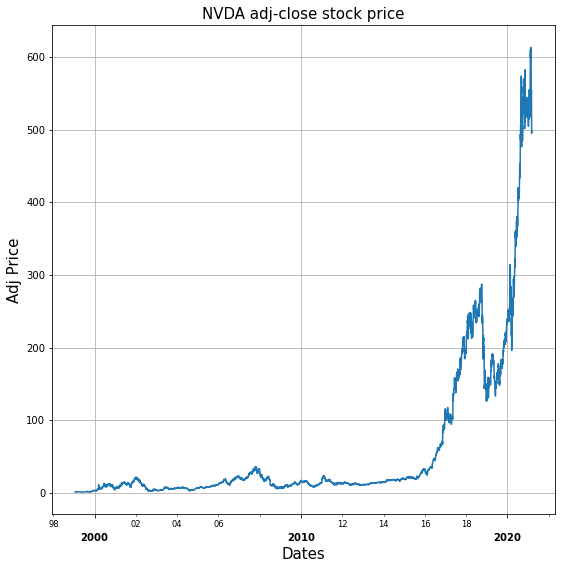

In [13]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(9, 9))

# Add x-axis and y-axis
ax.plot(df.index.values, df['Adj Close'])

# Define the date format
date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
format_xaxis(fig)

plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Adj Price', fontsize = 15)
plt.grid(True)
plt.title('NVDA adj-close stock price', fontsize = 15)
plt.savefig('./images/NVDA_dataset.jpg')
plt.show()


### Data Preprocessing by Using 7-prior-Stock-Day As A Sliding Window

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		x = dataset[i:(i+look_back)+1]
		dataX.append(x[:-1])
		dataY.append(x[-1])
	return np.array(dataX), np.array(dataY)

In [15]:
x_7_train, y_7_train = create_dataset(train, 7)
x_7_val, y_7_val = create_dataset(val, 7)
x_7_test, y_7_test = create_dataset(test, 7)

## Training 
Train the same architecture models with different hidden neurons, here the hyperparmeters are epochs = 50 / batchsize = 32

In [16]:
def model_fit(model, epochs, hidden_layer, batch_size, x_train, y_train, x_val, y_val, activation):
    # define the keras 7-20-1 model
    model.add(Dense(hidden_layer, input_dim=7, activation=activation))
    model.add(Dense(1, activation='relu'))
    # compile the keras model
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]) #  1- (MSE/100)
    # fit the keras model on the dataset
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return model, history

### 7-40-1

In [17]:
model_7_40_1 = Sequential()
model_7_40_1_relu, history_7_40_1_relu = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='relu')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 51us/step - loss: 1.6333 - mean_squared_error: 1.6333 - val_loss: 0.9303 - val_mean_squared_error: 0.9303
Epoch 2/50
3333/3333 [==============================] - 0s 27us/step - loss: 0.7537 - mean_squared_error: 0.7537 - val_loss: 0.6841 - val_mean_squared_error: 0.6841
Epoch 3/50
3333/3333 [==============================] - 0s 26us/step - loss: 0.6578 - mean_squared_error: 0.6578 - val_loss: 0.6165 - val_mean_squared_error: 0.6165
Epoch 4/50
3333/3333 [==============================] - 0s 25us/step - loss: 0.5737 - mean_squared_error: 0.5737 - val_loss: 0.5571 - val_mean_squared_error: 0.5571
Epoch 5/50
3333/3333 [==============================] - 0s 26us/step - loss: 0.4880 - mean_squared_error: 0.4880 - val_loss: 0.4184 - val_mean_squared_error: 0.4184
Epoch 6/50
3333/3333 [==============================] - 0s 29us/step - loss: 0.4484 - mean_squared_error: 0.4484 - val_loss: 0.

In [22]:
model_7_40_1 = Sequential()
model_7_40_1_sigmoid, history_7_40_1_sigmoid = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='sigmoid')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 59us/step - loss: 117.3712 - mean_squared_error: 117.3712 - val_loss: 373.5421 - val_mean_squared_error: 373.5421
Epoch 2/50
3333/3333 [==============================] - 0s 26us/step - loss: 59.1259 - mean_squared_error: 59.1260 - val_loss: 312.3347 - val_mean_squared_error: 312.3347
Epoch 3/50
3333/3333 [==============================] - 0s 30us/step - loss: 43.7609 - mean_squared_error: 43.7609 - val_loss: 273.2066 - val_mean_squared_error: 273.2066
Epoch 4/50
3333/3333 [==============================] - 0s 28us/step - loss: 34.5064 - mean_squared_error: 34.5064 - val_loss: 244.9071 - val_mean_squared_error: 244.9072
Epoch 5/50
3333/3333 [==============================] - 0s 27us/step - loss: 27.9069 - mean_squared_error: 27.9069 - val_loss: 222.6762 - val_mean_squared_error: 222.6763
Epoch 6/50
3333/3333 [==============================] - 0s 28us/step - loss: 22.8568 - mean_squ

In [23]:
model_7_40_1 = Sequential()
model_7_40_1_softmax, history_7_40_1_softmax = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='softmax')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 69us/step - loss: 167.9182 - mean_squared_error: 167.9182 - val_loss: 584.0066 - val_mean_squared_error: 584.0065
Epoch 2/50
3333/3333 [==============================] - 0s 29us/step - loss: 159.2506 - mean_squared_error: 159.2506 - val_loss: 561.6032 - val_mean_squared_error: 561.6032
Epoch 3/50
3333/3333 [==============================] - 0s 29us/step - loss: 151.1569 - mean_squared_error: 151.1569 - val_loss: 550.6724 - val_mean_squared_error: 550.6724
Epoch 4/50
3333/3333 [==============================] - 0s 29us/step - loss: 146.0982 - mean_squared_error: 146.0982 - val_loss: 541.2866 - val_mean_squared_error: 541.2866
Epoch 5/50
3333/3333 [==============================] - 0s 29us/step - loss: 141.5958 - mean_squared_error: 141.5958 - val_loss: 532.5651 - val_mean_squared_error: 532.5651
Epoch 6/50
3333/3333 [==============================] - 0s 30us/step - loss: 137.3899 -

In [25]:
model_7_40_1 = Sequential()
model_7_40_1_softplus, history_7_40_1_softplus = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='softplus')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 72us/step - loss: 12.1206 - mean_squared_error: 12.1206 - val_loss: 0.8421 - val_mean_squared_error: 0.8421
Epoch 2/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.5288 - mean_squared_error: 0.5288 - val_loss: 0.5548 - val_mean_squared_error: 0.5548
Epoch 3/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.4073 - mean_squared_error: 0.4073 - val_loss: 0.5840 - val_mean_squared_error: 0.5840
Epoch 4/50
3333/3333 [==============================] - 0s 32us/step - loss: 0.3547 - mean_squared_error: 0.3547 - val_loss: 0.3779 - val_mean_squared_error: 0.3779
Epoch 5/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.3268 - mean_squared_error: 0.3268 - val_loss: 0.3125 - val_mean_squared_error: 0.3125
Epoch 6/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.3010 - mean_squared_error: 0.3010 - val_loss: 

In [27]:
model_7_40_1 = Sequential()
model_7_40_1_tanh, history_7_40_1_tanh = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='tanh')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 71us/step - loss: 92.3687 - mean_squared_error: 92.3687 - val_loss: 332.2466 - val_mean_squared_error: 332.2466
Epoch 2/50
3333/3333 [==============================] - 0s 30us/step - loss: 44.3197 - mean_squared_error: 44.3197 - val_loss: 266.8491 - val_mean_squared_error: 266.8492
Epoch 3/50
3333/3333 [==============================] - 0s 29us/step - loss: 29.4679 - mean_squared_error: 29.4679 - val_loss: 224.4729 - val_mean_squared_error: 224.4729
Epoch 4/50
3333/3333 [==============================] - 0s 30us/step - loss: 21.0378 - mean_squared_error: 21.0378 - val_loss: 195.3310 - val_mean_squared_error: 195.3310
Epoch 5/50
3333/3333 [==============================] - 0s 30us/step - loss: 15.8976 - mean_squared_error: 15.8976 - val_loss: 173.9403 - val_mean_squared_error: 173.9403
Epoch 6/50
3333/3333 [==============================] - 0s 31us/step - loss: 12.5948 - mean_squar

In [28]:
model_7_40_1 = Sequential()
model_7_40_1_selu, history_7_40_1_selu = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='selu')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 112us/step - loss: 1.3620 - mean_squared_error: 1.3620 - val_loss: 0.4840 - val_mean_squared_error: 0.4840
Epoch 2/50
3333/3333 [==============================] - 0s 34us/step - loss: 0.3972 - mean_squared_error: 0.3972 - val_loss: 0.5892 - val_mean_squared_error: 0.5892
Epoch 3/50
3333/3333 [==============================] - 0s 36us/step - loss: 0.3851 - mean_squared_error: 0.3851 - val_loss: 0.3530 - val_mean_squared_error: 0.3530
Epoch 4/50
3333/3333 [==============================] - 0s 35us/step - loss: 0.3462 - mean_squared_error: 0.3462 - val_loss: 0.3376 - val_mean_squared_error: 0.3376
Epoch 5/50
3333/3333 [==============================] - 0s 35us/step - loss: 0.3381 - mean_squared_error: 0.3381 - val_loss: 0.3951 - val_mean_squared_error: 0.3951
Epoch 6/50
3333/3333 [==========

In [32]:
model_7_40_1 = Sequential()
model_7_40_1_elu, history_7_40_1_elu = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='elu')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 87us/step - loss: 1.2002 - mean_squared_error: 1.2002 - val_loss: 0.6360 - val_mean_squared_error: 0.6360
Epoch 2/50
3333/3333 [==============================] - 0s 34us/step - loss: 0.4198 - mean_squared_error: 0.4198 - val_loss: 0.5206 - val_mean_squared_error: 0.5206
Epoch 3/50
3333/3333 [==============================] - 0s 32us/step - loss: 0.3839 - mean_squared_error: 0.3839 - val_loss: 0.3485 - val_mean_squared_error: 0.3485
Epoch 4/50
3333/3333 [==============================] - 0s 33us/step - loss: 0.3796 - mean_squared_error: 0.3796 - val_loss: 0.4683 - val_mean_squared_error: 0.4683
Epoch 5/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.3670 - mean_squared_error: 0.3670 - val_loss: 0.6169 - val_mean_squared_error: 0.6169
Epoch 6/50
3333/3333 [==============================] - 0s 31us/step - loss: 0.3469 - mean_squared_error: 0.3469 - val_loss: 0.

## Accuracy vs Epochs for each architecture

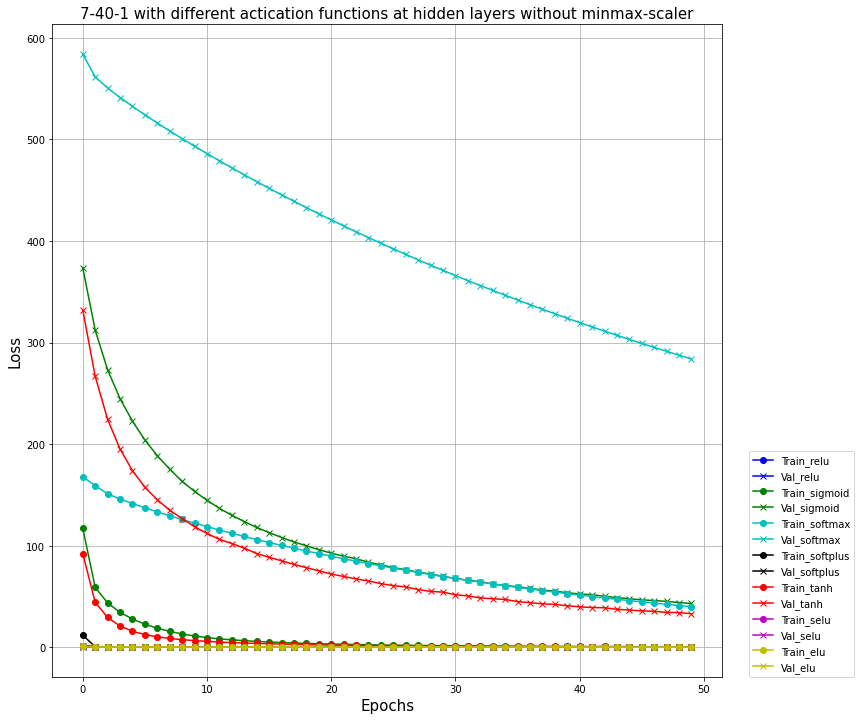

In [33]:
plt.figure(figsize=(12, 12))

# plt.subplot(221)
plt.plot(np.asarray(history_7_40_1_relu.history['loss']).reshape(-1,1), label = 'Train_relu',   marker='o', color = 'b')
plt.plot(np.asarray(history_7_40_1_relu.history['val_loss']).reshape(-1,1), label = 'Val_relu', marker='x', color = 'b')

plt.plot(np.asarray(history_7_40_1_sigmoid.history['loss']).reshape(-1,1), label = 'Train_sigmoid', marker='o', color = 'g')
plt.plot(np.asarray(history_7_40_1_sigmoid.history['val_loss']).reshape(-1,1), label = 'Val_sigmoid', marker='x', color = 'g')

plt.plot(np.asarray(history_7_40_1_softmax.history['loss']).reshape(-1,1), label = 'Train_softmax', marker='o', color = 'c')
plt.plot(np.asarray(history_7_40_1_softmax.history['val_loss']).reshape(-1,1), label = 'Val_softmax', marker='x', color = 'c')

plt.plot(np.asarray(history_7_40_1_softplus.history['loss']).reshape(-1,1), label = 'Train_softplus', marker='o', color = 'k')
plt.plot(np.asarray(history_7_40_1_softplus.history['val_loss']).reshape(-1,1), label = 'Val_softplus', marker='x', color = 'k')

plt.plot(np.asarray(history_7_40_1_tanh.history['loss']).reshape(-1,1), label = 'Train_tanh', marker='o', color = 'r')
plt.plot(np.asarray(history_7_40_1_tanh.history['val_loss']).reshape(-1,1), label = 'Val_tanh', marker='x', color = 'r')

plt.plot(np.asarray(history_7_40_1_selu.history['loss']).reshape(-1,1), label = 'Train_selu', marker='o', color = 'm')
plt.plot(np.asarray(history_7_40_1_selu.history['val_loss']).reshape(-1,1), label = 'Val_selu', marker='x', color = 'm')

plt.plot(np.asarray(history_7_40_1_elu.history['loss']).reshape(-1,1), label = 'Train_elu', marker='o', color = 'y')
plt.plot(np.asarray(history_7_40_1_elu.history['val_loss']).reshape(-1,1), label = 'Val_elu', marker='x', color = 'y')

plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title("7-40-1 with different actication functions at hidden layers without minmax-scaler", fontsize = 15)

plt.legend(loc=(1.04,0))

# # get the width of your widest label, since every label will need 
# # to shift by this amount after we align to the right
# renderer = plt.figure().canvas.get_renderer()
# shift = max([t.get_window_extent().width for t in plt.legend().get_texts()])
# for t in legend.get_texts():
#     t.set_ha('right') # ha is alias for horizontalalignment
#     t.set_position((shift,0))
plt.grid(True)
plt.savefig('./images/ANN_Loss_performance_diff_activation_function_without_minmax_scalor.jpg')

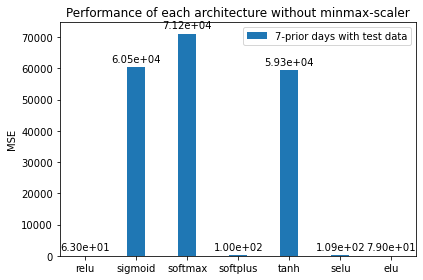

In [34]:
labels = ['relu', 'sigmoid', 'softmax', 'softplus', 'tanh', 'selu', 'elu']

# Prediction
y_test_pred_7_40_1_relu = model_7_40_1_relu.predict(x_7_test)
y_test_pred_7_40_1_sigmoid = model_7_40_1_sigmoid.predict(x_7_test)
y_test_pred_7_40_1_softmax = model_7_40_1_softmax.predict(x_7_test)
y_test_pred_7_40_1_softplus = model_7_40_1_softplus.predict(x_7_test)
y_test_pred_7_40_1_tanh = model_7_40_1_tanh.predict(x_7_test)
y_test_pred_7_40_1_selu = model_7_40_1_selu.predict(x_7_test)
y_test_pred_7_40_1_elu = model_7_40_1_elu.predict(x_7_test)

prior_7  = [mean_squared_error(y_7_test, y_test_pred_7_40_1_relu),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_sigmoid),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_softmax),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_softplus),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_tanh),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_selu),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_elu)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, prior_7, width, label='7-prior days with test data')

# plt.bar(y_pos, performance, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
# plt.ylabel('Usage')
# plt.title('Programming language usage')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Performance of each architecture without minmax-scaler')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2e}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)


fig.tight_layout()

plt.savefig('./images/MSE_performance_ANN_diff_activation_functions_without_minmax_scalor.jpg')
plt.show()

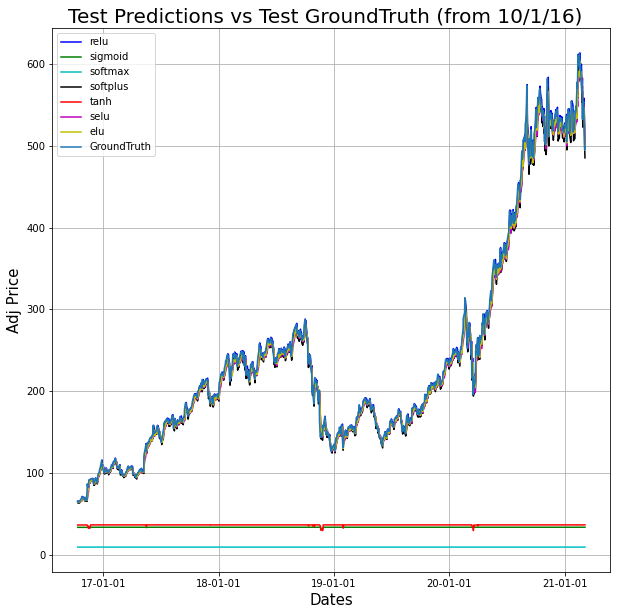

In [35]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(date[-1106:], y_test_pred_7_40_1_relu,     label = 'relu', color = 'b')
ax.plot(date[-1106:], y_test_pred_7_40_1_sigmoid,  label = 'sigmoid', color = 'g')
ax.plot(date[-1106:], y_test_pred_7_40_1_softmax,  label = 'softmax', color = 'c')
ax.plot(date[-1106:], y_test_pred_7_40_1_softplus, label = 'softplus', color = 'k')
ax.plot(date[-1106:], y_test_pred_7_40_1_tanh,     label = 'tanh', color = 'r')
ax.plot(date[-1106:], y_test_pred_7_40_1_selu,     label = 'selu', color = 'm')
ax.plot(date[-1106:], y_test_pred_7_40_1_elu,      label = 'elu', color = 'y')
ax.plot(date[-1106:], y_7_test, label = 'GroundTruth')

# Define the date format
date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))

# Add plot details
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Adj Price', fontsize = 15)
plt.grid(True)
plt.title('Test Predictions vs Test GroundTruth (from 10/1/16)  ', fontsize = 20)
plt.legend()

plt.savefig('./images/ANN_prediction_with_diff_activation_functions_without_minmax_scalor.jpg')
plt.show()


## Qb
 As we discussed in class, one of the biggest issues with the ANN is its lack of memory when
handling time-series data, and LSTM can potentially address this problem. Try to design an LSTM
model for NVDA price prediction. Feel free to explore the possible designs of LSTM and the number of 
past days’ adjusted closing price to use as input. Report the best model you can obtain that yields
highest accuracy (lowest MSE). Plot your predicted adjusted closing prices from 10/1/16 to now and the
actual prices with respect to time, and report the MSE. Does LSTM model provide higher accuracy
(lower MSE) on the test data? 

In [36]:
# load column[Adj Close] into df
df = 0
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
date = df['Date']
date = pd.to_datetime(date, format='%Y-%m-%d')

df = df.set_index('Date')
X = df['Adj Close'].to_numpy()

# scaler = MinMaxScaler()
# X = X.reshape(-1, 1)
# X = scaler.fit_transform(X)

# split into 60:20:20
train = X[0:int(len(X)*0.6)+1]
val = X[int(len(X)*0.6)+1:int(len(X)*0.8)+1]
test = X[int(len(X)*0.8)+1:]

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,1.750000,1.953125,1.552083,1.640625,1.508412,67867200
1999-01-25,1.770833,1.833333,1.640625,1.812500,1.666436,12762000
1999-01-26,1.833333,1.869792,1.645833,1.671875,1.537143,8580000
1999-01-27,1.677083,1.718750,1.583333,1.666667,1.532354,6109200
1999-01-28,1.666667,1.677083,1.651042,1.661458,1.527566,5688000
...,...,...,...,...,...,...
2021-03-01,555.000000,557.000000,542.130005,553.669983,553.669983,8802500
2021-03-02,556.000000,556.820007,535.840027,536.250000,536.250000,6585500
2021-03-03,537.049988,538.059998,511.950012,512.190002,512.190002,9408000


In [37]:
# load column[Adj Close] into df
df = 0
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
date = df['Date']
date = pd.to_datetime(date, format='%Y-%m-%d')

df = df.set_index('Date')
X = df['Adj Close'].to_numpy()

# scaler = MinMaxScaler()
# X = X.reshape(-1, 1)
# X = scaler.fit_transform(X)

# split into 60:20:20
train = X[0:int(len(X)*0.6)+1]
val = X[int(len(X)*0.6)+1:int(len(X)*0.8)+1]
test = X[int(len(X)*0.8)+1:]

# 7 prior days
x_7_train,   y_7_train = create_dataset(train, 7)
x_7_val,     y_7_val = create_dataset(val, 7)
x_7_test,    y_7_test = create_dataset(test, 7)

x_7_train = np.reshape(x_7_train, (x_7_train.shape[0], 1, x_7_train.shape[1]))
x_7_val   = np.reshape(x_7_val, (x_7_val.shape[0], 1, x_7_val.shape[1]))
x_7_test  = np.reshape(x_7_test, (x_7_test.shape[0], 1, x_7_test.shape[1]))

# 14 prior days
x_14_train,   y_14_train = create_dataset(train, 14)
x_14_val,     y_14_val = create_dataset(val, 14)
x_14_test,    y_14_test = create_dataset(test, 14)

x_14_train = np.reshape(x_14_train, (x_14_train.shape[0], 1, x_14_train.shape[1]))
x_14_val   = np.reshape(x_14_val,   (x_14_val.shape[0], 1,   x_14_val.shape[1]))
x_14_test  = np.reshape(x_14_test,  (x_14_test.shape[0], 1,  x_14_test.shape[1]))

# 21 prior days
x_21_train,   y_21_train = create_dataset(train, 21)
x_21_val,     y_21_val = create_dataset(val, 21)
x_21_test,    y_21_test = create_dataset(test, 21)

x_21_train = np.reshape(x_21_train, (x_21_train.shape[0], 1, x_21_train.shape[1]))
x_21_val   = np.reshape(x_21_val,   (x_21_val.shape[0], 1,   x_21_val.shape[1]))
x_21_test  = np.reshape(x_21_test,  (x_21_test.shape[0], 1,  x_21_test.shape[1]))

# 28 prior days
x_28_train,   y_28_train = create_dataset(train, 28)
x_28_val,     y_28_val = create_dataset(val, 28)
x_28_test,    y_28_test = create_dataset(test, 28)

x_28_train = np.reshape(x_28_train, (x_28_train.shape[0], 1, x_28_train.shape[1]))
x_28_val   = np.reshape(x_28_val,   (x_28_val.shape[0], 1,   x_28_val.shape[1]))
x_28_test  = np.reshape(x_28_test,  (x_28_test.shape[0], 1,  x_28_test.shape[1]))

train_x_list = [x_7_train, x_14_train, x_21_train, x_28_train]
train_y_list = [y_7_train, y_14_train, y_21_train, y_28_train]
val_x_list   = [x_7_val, x_14_val, x_21_val, x_28_val]
val_y_list   = [y_7_val, y_14_val, y_21_val, y_28_val]
test_x_list  = [x_7_test, x_14_test, x_21_test, x_28_test]
test_y_list  = [y_7_test, y_14_test, y_21_test, y_28_test]
input_list   = [7, 14, 21, 28]

y_train_pred_list = list()
y_val_pred_list = list()
y_test_pred_list = list()

trainScore = list()
valScore = list()
testScore = list()

# test_list  = [x_7_test, x_14_test, x_21_test, x_28_test]
# create and fit the LSTM network
histories = list()
for i in range(len(train_x_list)):
    model = Sequential()
    model.add(LSTM(40, input_shape=(1, input_list[i])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_x_list[i], train_y_list[i], epochs=100, batch_size=32, verbose=2, validation_data=(val_x_list[i], val_y_list[i]))
    histories.append(history)

    y_train_pred_list.append(model.predict(train_x_list[i]))
    trainScore.append(mean_squared_error(train_y_list[i], y_train_pred_list[i]))
    
    y_val_pred_list.append(model.predict(val_x_list[i]))   
    valScore.append(mean_squared_error(val_y_list[i], y_val_pred_list[i]))

    y_test_pred_list.append(model.predict(test_x_list[i]))
    testScore.append(mean_squared_error(test_y_list[i], y_test_pred_list[i]))
    

loss: 0.7965 - val_loss: 55.4040
Epoch 35/100
 - 0s - loss: 0.7375 - val_loss: 53.7685
Epoch 36/100
 - 0s - loss: 0.7145 - val_loss: 52.4419
Epoch 37/100
 - 0s - loss: 0.7100 - val_loss: 51.2894
Epoch 38/100
 - 0s - loss: 0.6298 - val_loss: 50.1976
Epoch 39/100
 - 0s - loss: 0.5955 - val_loss: 49.1241
Epoch 40/100
 - 0s - loss: 0.5687 - val_loss: 48.5420
Epoch 41/100
 - 0s - loss: 0.5819 - val_loss: 46.8190
Epoch 42/100
 - 0s - loss: 0.5487 - val_loss: 45.8435
Epoch 43/100
 - 0s - loss: 0.5261 - val_loss: 44.8077
Epoch 44/100
 - 0s - loss: 0.4988 - val_loss: 43.8274
Epoch 45/100
 - 0s - loss: 0.5887 - val_loss: 43.6163
Epoch 46/100
 - 0s - loss: 0.4882 - val_loss: 42.4131
Epoch 47/100
 - 0s - loss: 0.4325 - val_loss: 41.4684
Epoch 48/100
 - 0s - loss: 0.4256 - val_loss: 41.0246
Epoch 49/100
 - 0s - loss: 0.4281 - val_loss: 40.1223
Epoch 50/100
 - 0s - loss: 0.4012 - val_loss: 39.3764
Epoch 51/100
 - 0s - loss: 0.4002 - val_loss: 38.5761
Epoch 52/100
 - 0s - loss: 0.4615 - val_loss: 38.

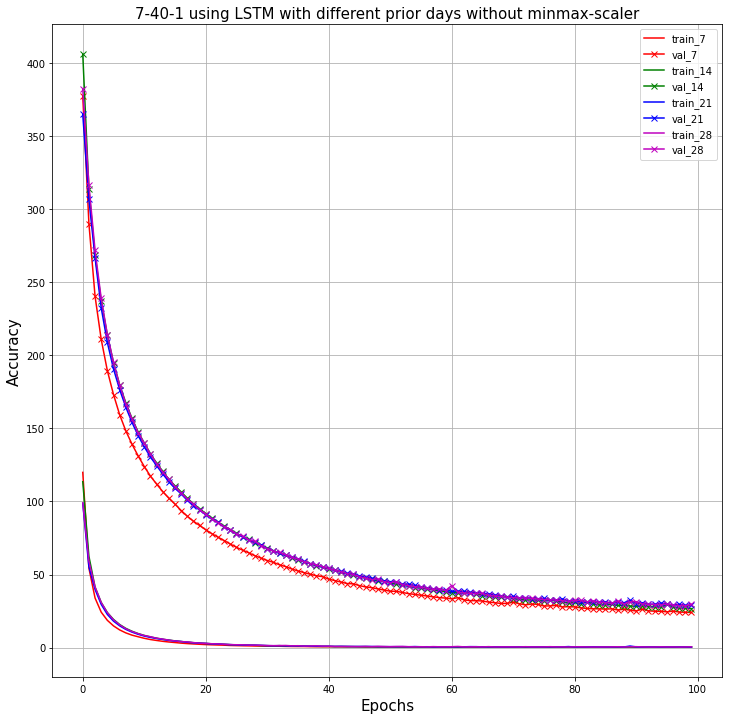

In [38]:
plt.figure(figsize=(12, 12))
label_train = ['train_7', 'train_14', 'train_21', 'train_28']
label_val = ['val_7', 'val_14', 'val_21', 'val_28']
color = ['r', 'g', 'b', 'm']

for i in range(len(train_x_list)):
    plt.plot(np.asarray(histories[i].history['loss']).reshape(-1,1), label = label_train[i], color = color[i])
    plt.plot(np.asarray(histories[i].history['val_loss']).reshape(-1,1), label = label_val[i], marker='x', color = color[i])

plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-40-1 using LSTM with different prior days without minmax-scaler", fontsize = 15)
plt.legend()
plt.grid(True)
plt.savefig('./images/LSTM_without_minmax_scalor_Accu_vs_Epochs.jpg')

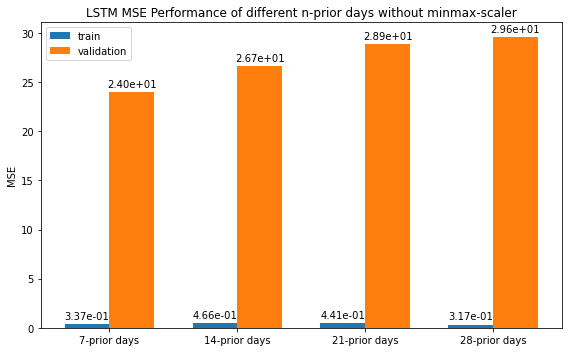

In [39]:
labels = ['7-prior days', '14-prior days', '21-prior days', '28-prior days']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, trainScore, width, label='train')
rects2 = ax.bar(x + width/2, valScore, width, label='validation')
# rects3 = ax.bar(x + 3*width/3, testScore, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('LSTM MSE Performance of different n-prior days without minmax-scaler')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2e}'.format((height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig('./images/LSTM_MSE_train_val_without_minmax_scalor_performance.jpg')
plt.show()

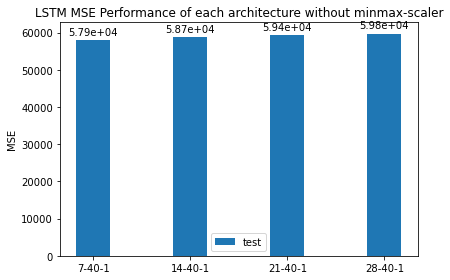

In [40]:
labels = ['7-40-1', '14-40-1', '21-40-1', '28-40-1']

prior_7  = [mean_squared_error(test_y_list[0], y_test_pred_list[0]),
            mean_squared_error(test_y_list[1], y_test_pred_list[1]),
            mean_squared_error(test_y_list[2], y_test_pred_list[2]),
            mean_squared_error(test_y_list[3], y_test_pred_list[3])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, prior_7, width, label='test')

# plt.bar(y_pos, performance, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
# plt.ylabel('Usage')
# plt.title('Programming language usage')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('LSTM MSE Performance of each architecture without minmax-scaler')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2e}'.format((height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)


fig.tight_layout()

plt.savefig('./images/LSTM_MSE_test_performance_without_minmax_scalor.jpg')
plt.show()

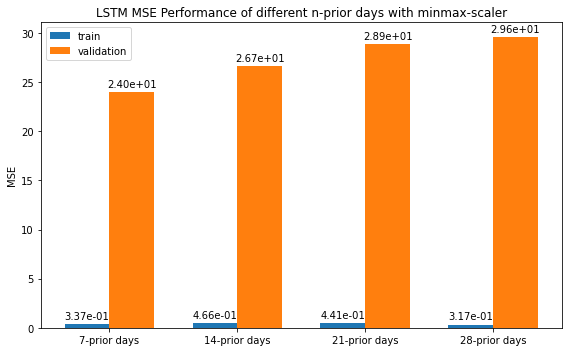

In [41]:
labels = ['7-prior days', '14-prior days', '21-prior days', '28-prior days']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, trainScore, width, label='train')
rects2 = ax.bar(x + width/2, valScore, width, label='validation')
# rects3 = ax.bar(x + 3*width/3, testScore, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('LSTM MSE Performance of different n-prior days with minmax-scaler')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2e}'.format((height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# plt.savefig('./images/LSTM_MSE_diff_inputs_with_minmax_scalor_performance.jpg')
plt.show()

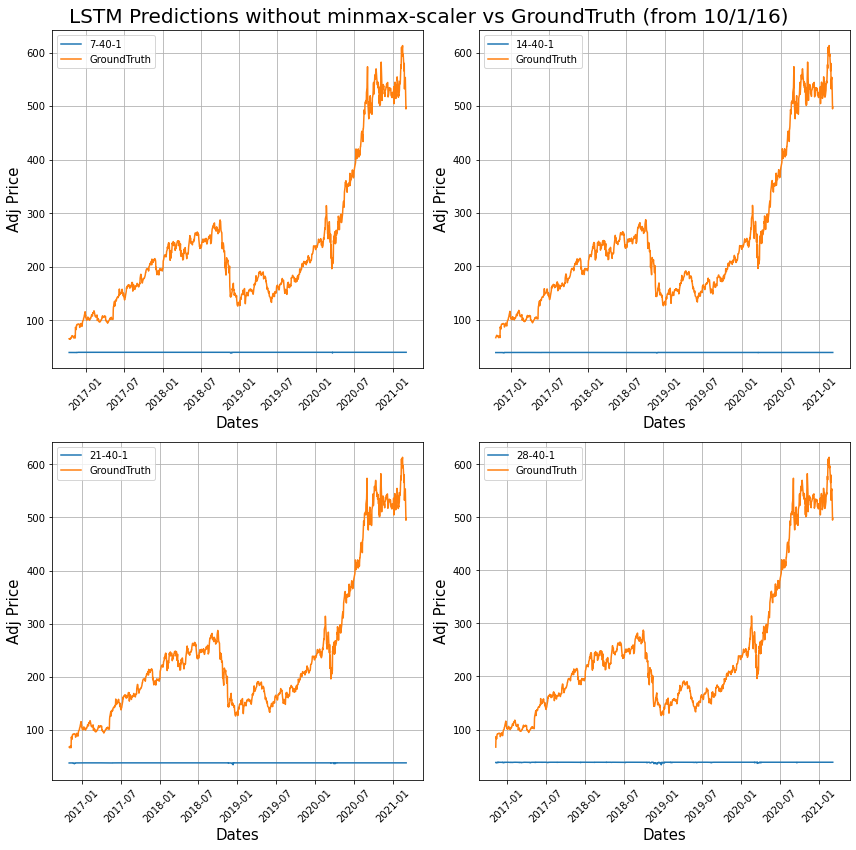

In [42]:
labels = ['7-40-1', '14-40-1', '21-40-1', '28-40-1']
nums = [1106, 1099, 1092, 1085]
subplots = [221, 222, 223, 224]
# Create figure and plot space
plt.figure(figsize=(12, 12))
plt.suptitle('LSTM Predictions without minmax-scaler vs GroundTruth (from 10/1/16)', fontsize = 20)
for i in range(len(train_x_list)):
    plt.subplot(subplots[i])
    # Add x-axis and y-axis
    plt.plot(date[-nums[i]:], y_test_pred_list[i], label = labels[i])
    plt.plot(date[-nums[i]:], test_y_list[i], label = 'GroundTruth')

    # Define the date format
    date_form = DateFormatter("%y-%m")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.YearLocator(3, month=1))
    plt.xticks(rotation = 45)

    # Add plot details
    plt.xlabel('Dates', fontsize = 15)
    plt.ylabel('Adj Price', fontsize = 15)
    plt.grid(True)
    # plt.title('LSTM Predictions vs GroundTruth (from 10/1/16)', fontsize = 20)
    plt.legend()

plt.savefig('./images/LSTM_Predictions_vs_GroundTruth_without_minmax_scaler.jpg')
plt.tight_layout()
plt.show()


## Q(C)
Bonus questions for 40625; mandatory for 60625 (10 points): Does any preprocessing on the input data
help with your models in (a) and (b)?

### ANN 7-40-1 with minmax-scalor

In [62]:
# load column[Adj Close] into df
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
date = df['Date']
date = pd.to_datetime(date, format='%Y-%m-%d')

df = df.set_index('Date')
X = df['Adj Close'].to_numpy()

scaler = MinMaxScaler()
X = X.reshape(-1, 1)
X = scaler.fit_transform(X)

X = X.reshape(5566, )

# split into 60:20:20
train = X[0:int(len(X)*0.6)+1]
val = X[int(len(X)*0.6)+1:int(len(X)*0.8)+1]
test = X[int(len(X)*0.8)+1:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		x = dataset[i:(i+look_back)+1]
		dataX.append(x[:-1])
		dataY.append(x[-1])
	return np.array(dataX), np.array(dataY)

x_7_train, y_7_train = create_dataset(train, 7)
x_7_val, y_7_val = create_dataset(val, 7)
x_7_test, y_7_test = create_dataset(test, 7)

def model_fit(model, epochs, hidden_layer, batch_size, x_train, y_train, x_val, y_val, activation):
    # define the keras 7-20-1 model
    model.add(Dense(hidden_layer, input_dim=7, activation=activation))
    model.add(Dense(1, activation='relu'))
    # compile the keras model
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]) #  1- (MSE/100)
    # fit the keras model on the dataset
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return model, history

In [63]:
model_7_40_1 = Sequential()
model_7_40_1_relu, history_7_40_1_relu = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='relu')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 1s 155us/step - loss: 1.7035e-05 - mean_squared_error: 1.7035e-05 - val_loss: 8.9132e-06 - val_mean_squared_error: 8.9132e-06
Epoch 2/50
3333/3333 [==============================] - 0s 47us/step - loss: 1.3589e-06 - mean_squared_error: 1.3589e-06 - val_loss: 7.0912e-06 - val_mean_squared_error: 7.0912e-06
Epoch 3/50
3333/3333 [==============================] - 0s 43us/step - loss: 1.3172e-06 - mean_squared_error: 1.3172e-06 - val_loss: 7.6860e-06 - val_mean_squared_error: 7.6860e-06
Epoch 4/50
3333/3333 [==============================] - 0s 40us/step - loss: 1.3169e-06 - mean_squared_error: 1.3169e-06 - val_loss: 6.5163e-06 - val_mean_squared_error: 6.5163e-06
Epoch 5/50
3333/3333 [==============================] - 0s 46us/step - loss: 1.2710e-06 - mean_squared_error: 1.2710e-06 - val_loss: 6.5679e-06 - val_mean_squared_error: 6.5679e-06
Epoch 6/50
3333/3333 [========================

In [71]:
model_7_40_1 = Sequential()
model_7_40_1_sigmoid, history_7_40_1_sigmoid = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='sigmoid')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 1s 177us/step - loss: 0.5495 - mean_squared_error: 0.5495 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/50
3333/3333 [==============================] - 0s 48us/step - loss: 5.3972e-04 - mean_squared_error: 5.3972e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/50
3333/3333 [==============================] - 0s 50us/step - loss: 3.4473e-04 - mean_squared_error: 3.4473e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/50
3333/3333 [==============================] - 0s 48us/step - loss: 3.3846e-04 - mean_squared_error: 3.3846e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/50
3333/3333 [==============================] - 0s 53us/step - loss: 3.2989e-04 - mean_squared_error: 3.2989e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 6/50
3333/3333 [==============================] - 0s 44us/step - loss: 3.1905e-04 - mean

In [72]:
model_7_40_1 = Sequential()
model_7_40_1_softmax, history_7_40_1_softmax = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='softmax')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 1s 182us/step - loss: 1.0793e-04 - mean_squared_error: 1.0793e-04 - val_loss: 4.6467e-04 - val_mean_squared_error: 4.6467e-04
Epoch 2/50
3333/3333 [==============================] - 0s 51us/step - loss: 8.5065e-05 - mean_squared_error: 8.5065e-05 - val_loss: 3.9660e-04 - val_mean_squared_error: 3.9660e-04
Epoch 3/50
3333/3333 [==============================] - 0s 53us/step - loss: 6.3544e-05 - mean_squared_error: 6.3544e-05 - val_loss: 3.2723e-04 - val_mean_squared_error: 3.2723e-04
Epoch 4/50
3333/3333 [==============================] - 0s 51us/step - loss: 4.5116e-05 - mean_squared_error: 4.5116e-05 - val_loss: 2.1852e-04 - val_mean_squared_error: 2.1852e-04
Epoch 5/50
3333/3333 [==============================] - 0s 53us/step - loss: 3.0448e-05 - mean_squared_error: 3.0448e-05 - val_loss: 1.2192e-04 - val_mean_squared_error: 1.2192e-04
Epoch 6/50
3333/3333 [========================

In [73]:
model_7_40_1 = Sequential()
model_7_40_1_softplus, history_7_40_1_softplus = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='softplus')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 1s 183us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/50
3333/3333 [==============================] - 0s 46us/step - loss: 3.9470e-04 - mean_squared_error: 3.9470e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/50
3333/3333 [==============================] - 0s 47us/step - loss: 3.9470e-04 - mean_squared_error: 3.9470e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/50
3333/3333 [==============================] - 0s 48us/step - loss: 3.9470e-04 - mean_squared_error: 3.9470e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/50
3333/3333 [==============================] - 0s 50us/step - loss: 3.9470e-04 - mean_squared_error: 3.9470e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/50
3333/3333 [==============================] - 0s 64us/step - loss: 3.9470e-04 - mean

In [74]:
model_7_40_1 = Sequential()
model_7_40_1_tanh, history_7_40_1_tanh = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='tanh')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 1s 208us/step - loss: 1.0451e-05 - mean_squared_error: 1.0451e-05 - val_loss: 1.6351e-06 - val_mean_squared_error: 1.6351e-06
Epoch 2/50
3333/3333 [==============================] - 0s 50us/step - loss: 1.8407e-06 - mean_squared_error: 1.8407e-06 - val_loss: 1.5070e-06 - val_mean_squared_error: 1.5070e-06
Epoch 3/50
3333/3333 [==============================] - 0s 48us/step - loss: 1.7290e-06 - mean_squared_error: 1.7290e-06 - val_loss: 1.5085e-06 - val_mean_squared_error: 1.5085e-06
Epoch 4/50
3333/3333 [==============================] - 0s 49us/step - loss: 1.7023e-06 - mean_squared_error: 1.7023e-06 - val_loss: 1.3501e-06 - val_mean_squared_error: 1.3501e-06
Epoch 5/50
3333/3333 [==============================] - 0s 48us/step - loss: 1.6579e-06 - mean_squared_error: 1.6579e-06 - val_loss: 1.3591e-06 - val_mean_squared_error: 1.3591e-06
Epoch 6/50
3333/3333 [========================

In [76]:
model_7_40_1 = Sequential()
model_7_40_1_selu, history_7_40_1_selu = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='selu')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 1s 192us/step - loss: 1.3143e-05 - mean_squared_error: 1.3143e-05 - val_loss: 6.9493e-06 - val_mean_squared_error: 6.9493e-06
Epoch 2/50
3333/3333 [==============================] - 0s 55us/step - loss: 2.3952e-06 - mean_squared_error: 2.3952e-06 - val_loss: 3.0203e-06 - val_mean_squared_error: 3.0203e-06
Epoch 3/50
3333/3333 [==============================] - 0s 51us/step - loss: 1.9784e-06 - mean_squared_error: 1.9784e-06 - val_loss: 2.3756e-06 - val_mean_squared_error: 2.3756e-06
Epoch 4/50
3333/3333 [==============================] - 0s 58us/step - loss: 1.4310e-06 - mean_squared_error: 1.4310e-06 - val_loss: 1.4919e-06 - val_mean_squared_error: 1.4919e-06
Epoch 5/50
3333/3333 [==============================] - 0s 48us/step - loss: 1.7421e-06 - mean_squared_error: 1.7421e-06 - val_loss: 3.3733e-06 - val_mean_squared_error: 3.3733e-06
Epoch 6/50
3333/3333 [========================

In [77]:
model_7_40_1 = Sequential()
model_7_40_1_elu, history_7_40_1_elu = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val, activation='elu')

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 1s 209us/step - loss: 5.7593e-05 - mean_squared_error: 5.7593e-05 - val_loss: 4.5867e-06 - val_mean_squared_error: 4.5867e-06
Epoch 2/50
3333/3333 [==============================] - 0s 49us/step - loss: 2.6037e-06 - mean_squared_error: 2.6037e-06 - val_loss: 3.3700e-06 - val_mean_squared_error: 3.3700e-06
Epoch 3/50
3333/3333 [==============================] - 0s 47us/step - loss: 2.5605e-06 - mean_squared_error: 2.5605e-06 - val_loss: 2.5895e-06 - val_mean_squared_error: 2.5895e-06
Epoch 4/50
3333/3333 [==============================] - 0s 51us/step - loss: 2.1291e-06 - mean_squared_error: 2.1291e-06 - val_loss: 3.1269e-06 - val_mean_squared_error: 3.1269e-06
Epoch 5/50
3333/3333 [==============================] - 0s 55us/step - loss: 1.8774e-06 - mean_squared_error: 1.8774e-06 - val_loss: 2.9022e-06 - val_mean_squared_error: 2.9022e-06
Epoch 6/50
3333/3333 [========================

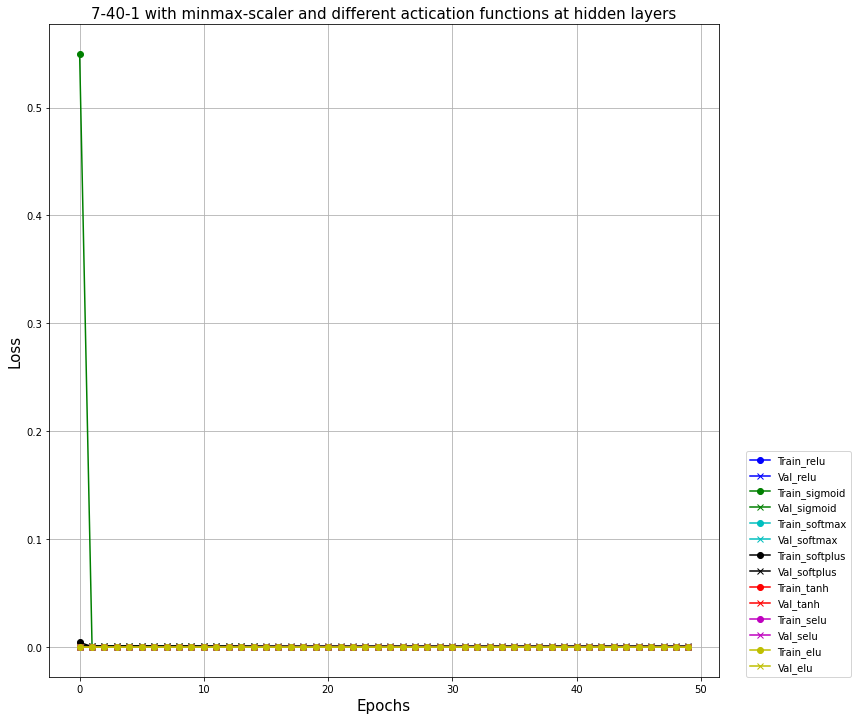

In [78]:
plt.figure(figsize=(12, 12))

# plt.subplot(221)
plt.plot(np.asarray(history_7_40_1_relu.history['loss']).reshape(-1,1), label = 'Train_relu',   marker='o', color = 'b')
plt.plot(np.asarray(history_7_40_1_relu.history['val_loss']).reshape(-1,1), label = 'Val_relu', marker='x', color = 'b')

plt.plot(np.asarray(history_7_40_1_sigmoid.history['loss']).reshape(-1,1), label = 'Train_sigmoid', marker='o', color = 'g')
plt.plot(np.asarray(history_7_40_1_sigmoid.history['val_loss']).reshape(-1,1), label = 'Val_sigmoid', marker='x', color = 'g')

plt.plot(np.asarray(history_7_40_1_softmax.history['loss']).reshape(-1,1), label = 'Train_softmax', marker='o', color = 'c')
plt.plot(np.asarray(history_7_40_1_softmax.history['val_loss']).reshape(-1,1), label = 'Val_softmax', marker='x', color = 'c')

plt.plot(np.asarray(history_7_40_1_softplus.history['loss']).reshape(-1,1), label = 'Train_softplus', marker='o', color = 'k')
plt.plot(np.asarray(history_7_40_1_softplus.history['val_loss']).reshape(-1,1), label = 'Val_softplus', marker='x', color = 'k')

plt.plot(np.asarray(history_7_40_1_tanh.history['loss']).reshape(-1,1), label = 'Train_tanh', marker='o', color = 'r')
plt.plot(np.asarray(history_7_40_1_tanh.history['val_loss']).reshape(-1,1), label = 'Val_tanh', marker='x', color = 'r')

plt.plot(np.asarray(history_7_40_1_selu.history['loss']).reshape(-1,1), label = 'Train_selu', marker='o', color = 'm')
plt.plot(np.asarray(history_7_40_1_selu.history['val_loss']).reshape(-1,1), label = 'Val_selu', marker='x', color = 'm')

plt.plot(np.asarray(history_7_40_1_elu.history['loss']).reshape(-1,1), label = 'Train_elu', marker='o', color = 'y')
plt.plot(np.asarray(history_7_40_1_elu.history['val_loss']).reshape(-1,1), label = 'Val_elu', marker='x', color = 'y')

plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title("7-40-1 with minmax-scaler and different actication functions at hidden layers", fontsize = 15)

plt.legend(loc=(1.04,0))

# # get the width of your widest label, since every label will need 
# # to shift by this amount after we align to the right
# renderer = plt.figure().canvas.get_renderer()
# shift = max([t.get_window_extent().width for t in plt.legend().get_texts()])
# for t in legend.get_texts():
#     t.set_ha('right') # ha is alias for horizontalalignment
#     t.set_position((shift,0))
plt.grid(True)
plt.savefig('./images/ANN_Loss_performance_diff_activation_function_with_minmax_scalor.jpg')

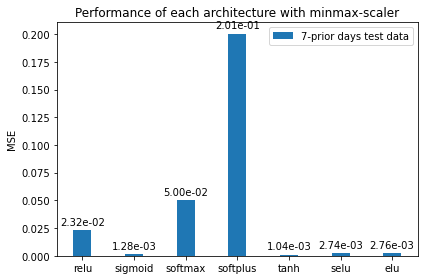

In [79]:
labels = ['relu', 'sigmoid', 'softmax', 'softplus', 'tanh', 'selu', 'elu']

# Prediction
y_test_pred_7_40_1_relu = model_7_40_1_relu.predict(x_7_test)
y_test_pred_7_40_1_sigmoid = model_7_40_1_sigmoid.predict(x_7_test)
y_test_pred_7_40_1_softmax = model_7_40_1_softmax.predict(x_7_test)
y_test_pred_7_40_1_softplus = model_7_40_1_softplus.predict(x_7_test)
y_test_pred_7_40_1_tanh = model_7_40_1_tanh.predict(x_7_test)
y_test_pred_7_40_1_selu = model_7_40_1_selu.predict(x_7_test)
y_test_pred_7_40_1_elu = model_7_40_1_elu.predict(x_7_test)

prior_7  = [mean_squared_error(y_7_test, y_test_pred_7_40_1_relu),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_sigmoid),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_softmax),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_softplus),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_tanh),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_selu),
            mean_squared_error(y_7_test, y_test_pred_7_40_1_elu)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, prior_7, width, label='7-prior days test data')

# plt.bar(y_pos, performance, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
# plt.ylabel('Usage')
# plt.title('Programming language usage')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Performance of each architecture with minmax-scaler')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2e}'.format((height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)


fig.tight_layout()

plt.savefig('./images/MSE_performance_ANN_diff_activation_functions_with_minmax_scalor.jpg')
plt.show()

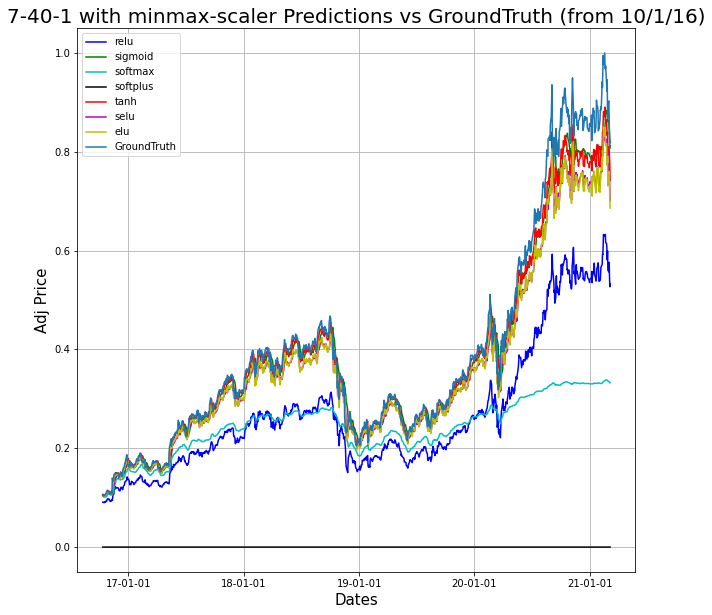

In [80]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(date[-1106:], y_test_pred_7_40_1_relu,     label = 'relu', color = 'b')
ax.plot(date[-1106:], y_test_pred_7_40_1_sigmoid,  label = 'sigmoid', color = 'g')
ax.plot(date[-1106:], y_test_pred_7_40_1_softmax,  label = 'softmax', color = 'c')
ax.plot(date[-1106:], y_test_pred_7_40_1_softplus, label = 'softplus', color = 'k')
ax.plot(date[-1106:], y_test_pred_7_40_1_tanh,     label = 'tanh', color = 'r')
ax.plot(date[-1106:], y_test_pred_7_40_1_selu,     label = 'selu', color = 'm')
ax.plot(date[-1106:], y_test_pred_7_40_1_elu,      label = 'elu', color = 'y')
ax.plot(date[-1106:], y_7_test, label = 'GroundTruth')

# Define the date format
date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))

# Add plot details
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Adj Price', fontsize = 15)
plt.grid(True)
plt.title('7-40-1 with minmax-scaler Predictions vs GroundTruth (from 10/1/16)', fontsize = 20)
plt.legend()

plt.savefig('./images/ANN_prediction_with_diff_activation_functions_with_minmax_scalor.jpg')
plt.show()


### LSTM 7/14/21/28-40-1 with minmax-scalor

In [81]:
# load column[Adj Close] into df
df = 0
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
date = df['Date']
date = pd.to_datetime(date, format='%Y-%m-%d')

df = df.set_index('Date')
X = df['Adj Close'].to_numpy()

scaler = MinMaxScaler()
X = X.reshape(-1, 1)
X = scaler.fit_transform(X)

# split into 60:20:20
train = X[0:int(len(X)*0.6)+1]
val = X[int(len(X)*0.6)+1:int(len(X)*0.8)+1]
test = X[int(len(X)*0.8)+1:]

# 7 prior days
x_7_train,   y_7_train = create_dataset(train, 7)
x_7_val,     y_7_val = create_dataset(val, 7)
x_7_test,    y_7_test = create_dataset(test, 7)

x_7_train = np.reshape(x_7_train, (x_7_train.shape[0], 1, x_7_train.shape[1]))
x_7_val   = np.reshape(x_7_val, (x_7_val.shape[0], 1, x_7_val.shape[1]))
x_7_test  = np.reshape(x_7_test, (x_7_test.shape[0], 1, x_7_test.shape[1]))

# 14 prior days
x_14_train,   y_14_train = create_dataset(train, 14)
x_14_val,     y_14_val = create_dataset(val, 14)
x_14_test,    y_14_test = create_dataset(test, 14)

x_14_train = np.reshape(x_14_train, (x_14_train.shape[0], 1, x_14_train.shape[1]))
x_14_val   = np.reshape(x_14_val,   (x_14_val.shape[0], 1,   x_14_val.shape[1]))
x_14_test  = np.reshape(x_14_test,  (x_14_test.shape[0], 1,  x_14_test.shape[1]))

# 21 prior days
x_21_train,   y_21_train = create_dataset(train, 21)
x_21_val,     y_21_val = create_dataset(val, 21)
x_21_test,    y_21_test = create_dataset(test, 21)

x_21_train = np.reshape(x_21_train, (x_21_train.shape[0], 1, x_21_train.shape[1]))
x_21_val   = np.reshape(x_21_val,   (x_21_val.shape[0], 1,   x_21_val.shape[1]))
x_21_test  = np.reshape(x_21_test,  (x_21_test.shape[0], 1,  x_21_test.shape[1]))

# 28 prior days
x_28_train,   y_28_train = create_dataset(train, 28)
x_28_val,     y_28_val = create_dataset(val, 28)
x_28_test,    y_28_test = create_dataset(test, 28)

x_28_train = np.reshape(x_28_train, (x_28_train.shape[0], 1, x_28_train.shape[1]))
x_28_val   = np.reshape(x_28_val,   (x_28_val.shape[0], 1,   x_28_val.shape[1]))
x_28_test  = np.reshape(x_28_test,  (x_28_test.shape[0], 1,  x_28_test.shape[1]))

train_x_list = [x_7_train, x_14_train, x_21_train, x_28_train]
train_y_list = [y_7_train, y_14_train, y_21_train, y_28_train]
val_x_list   = [x_7_val, x_14_val, x_21_val, x_28_val]
val_y_list   = [y_7_val, y_14_val, y_21_val, y_28_val]
test_x_list  = [x_7_test, x_14_test, x_21_test, x_28_test]
test_y_list  = [y_7_test, y_14_test, y_21_test, y_28_test]
input_list   = [7, 14, 21, 28]

y_train_pred_list = list()
y_val_pred_list = list()
y_test_pred_list = list()

trainScore = list()
valScore = list()
testScore = list()

# test_list  = [x_7_test, x_14_test, x_21_test, x_28_test]
# create and fit the LSTM network
histories = list()
for i in range(len(train_x_list)):
    model = Sequential()
    model.add(LSTM(40, input_shape=(1, input_list[i])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_x_list[i], train_y_list[i], epochs=100, batch_size=32, verbose=2, validation_data=(val_x_list[i], val_y_list[i]))
    histories.append(history)

    y_train_pred_list.append(model.predict(train_x_list[i]))
    trainScore.append(mean_squared_error(train_y_list[i], y_train_pred_list[i]))
    
    y_val_pred_list.append(model.predict(val_x_list[i]))   
    valScore.append(mean_squared_error(val_y_list[i], y_val_pred_list[i]))

    y_test_pred_list.append(model.predict(test_x_list[i]))
    testScore.append(mean_squared_error(test_y_list[i], y_test_pred_list[i]))
    

5/100
 - 0s - loss: 8.2012e-07 - val_loss: 1.5441e-06
Epoch 76/100
 - 0s - loss: 8.9152e-07 - val_loss: 9.3611e-07
Epoch 77/100
 - 0s - loss: 7.8801e-07 - val_loss: 6.9774e-07
Epoch 78/100
 - 0s - loss: 8.3424e-07 - val_loss: 6.3419e-07
Epoch 79/100
 - 0s - loss: 8.2172e-07 - val_loss: 6.7057e-07
Epoch 80/100
 - 0s - loss: 7.8756e-07 - val_loss: 9.3529e-07
Epoch 81/100
 - 0s - loss: 7.7197e-07 - val_loss: 7.5544e-07
Epoch 82/100
 - 0s - loss: 8.1906e-07 - val_loss: 7.6550e-07
Epoch 83/100
 - 0s - loss: 7.9387e-07 - val_loss: 6.6725e-07
Epoch 84/100
 - 0s - loss: 8.7875e-07 - val_loss: 6.8004e-07
Epoch 85/100
 - 0s - loss: 8.4376e-07 - val_loss: 6.2966e-07
Epoch 86/100
 - 0s - loss: 8.0875e-07 - val_loss: 6.7828e-07
Epoch 87/100
 - 0s - loss: 7.7362e-07 - val_loss: 7.0923e-07
Epoch 88/100
 - 0s - loss: 7.8008e-07 - val_loss: 7.3255e-07
Epoch 89/100
 - 0s - loss: 9.3692e-07 - val_loss: 8.3311e-07
Epoch 90/100
 - 0s - loss: 7.5382e-07 - val_loss: 6.7819e-07
Epoch 91/100
 - 0s - loss: 7.88

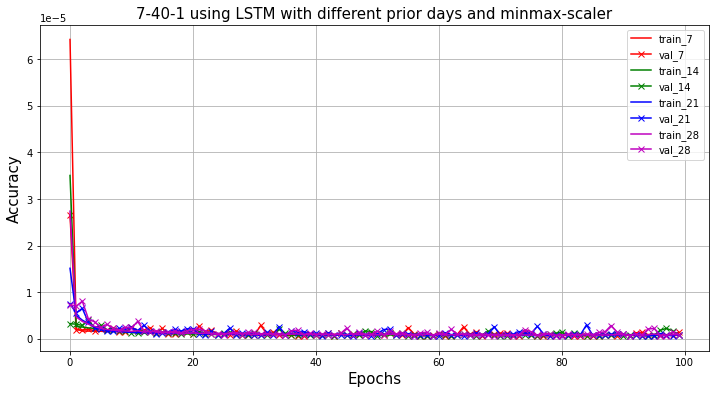

In [82]:
plt.figure(figsize=(12, 6))
label_train = ['train_7', 'train_14', 'train_21', 'train_28']
label_val = ['val_7', 'val_14', 'val_21', 'val_28']
color = ['r', 'g', 'b', 'm']
for i in range(len(train_x_list)):
    plt.plot(np.asarray(histories[i].history['loss']).reshape(-1,1), label = label_train[i], color = color[i])
    plt.plot(np.asarray(histories[i].history['val_loss']).reshape(-1,1), label = label_val[i], marker='x', color = color[i])
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-40-1 using LSTM with different prior days and minmax-scaler", fontsize = 15)
plt.legend()
plt.grid(True)
plt.savefig('./images/LSTM_with_minmax_scalor_Accu_vs_Epochs.jpg')

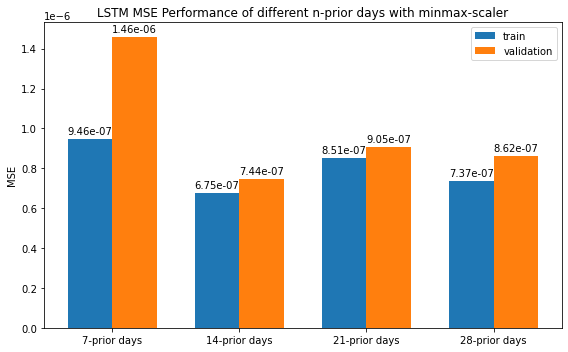

In [83]:
labels = ['7-prior days', '14-prior days', '21-prior days', '28-prior days']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, trainScore, width, label='train')
rects2 = ax.bar(x + width/2, valScore, width, label='validation')
# rects3 = ax.bar(x + 3*width/3, testScore, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('LSTM MSE Performance of different n-prior days with minmax-scaler')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2e}'.format((height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig('./images/LSTM_MSE_with_minmax_scalor_performance.jpg')
plt.show()

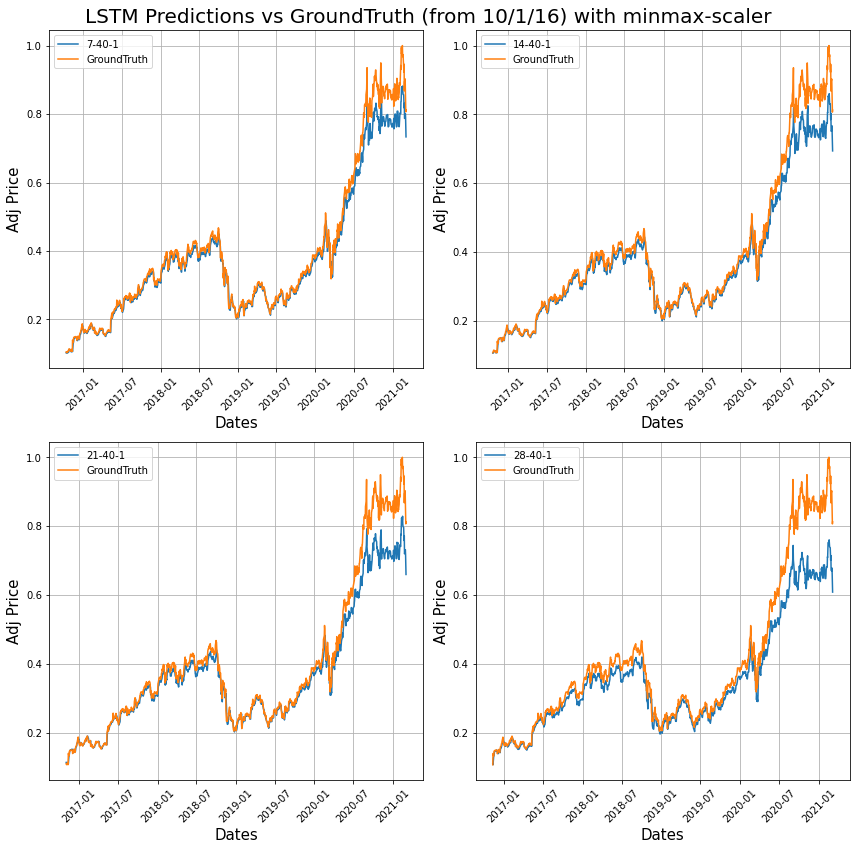

In [84]:
labels = ['7-40-1', '14-40-1', '21-40-1', '28-40-1']
nums = list()

for i in range(len(train_x_list)):
    nums.append(len(y_test_pred_list[i]))

subplots = [221, 222, 223, 224]
# Create figure and plot space
plt.figure(figsize=(12, 12))
plt.suptitle('LSTM Predictions vs GroundTruth (from 10/1/16) with minmax-scaler', fontsize = 20)
for i in range(len(train_x_list)):
    plt.subplot(subplots[i])
    # Add x-axis and y-axis
    plt.plot(date[-nums[i]:], y_test_pred_list[i], label = labels[i])
    plt.plot(date[-nums[i]:], test_y_list[i], label = 'GroundTruth')

    # Define the date format
    date_form = DateFormatter("%y-%m")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.YearLocator(3, month=1))
    plt.xticks(rotation = 45)

    # Add plot details
    plt.xlabel('Dates', fontsize = 15)
    plt.ylabel('Adj Price', fontsize = 15)
    plt.grid(True)
    # plt.title('LSTM Predictions vs GroundTruth (from 10/1/16)', fontsize = 20)
    plt.legend()

plt.savefig('./images/LSTM_Predictions_vs_GroundTruth_with_minmax_scaler.jpg')
plt.tight_layout()
plt.show()


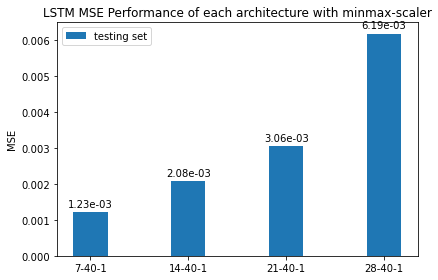

In [85]:
labels = ['7-40-1', '14-40-1', '21-40-1', '28-40-1']

prior_7  = [mean_squared_error(test_y_list[0], y_test_pred_list[0]),
            mean_squared_error(test_y_list[1], y_test_pred_list[1]),
            mean_squared_error(test_y_list[2], y_test_pred_list[2]),
            mean_squared_error(test_y_list[3], y_test_pred_list[3])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, prior_7, width, label='testing set')

# plt.bar(y_pos, performance, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
# plt.ylabel('Usage')
# plt.title('Programming language usage')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('LSTM MSE Performance of each architecture with minmax-scaler')
ax.set_xticks(x)
ax.set_xticklabels(labels = labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2e}'.format((height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)


fig.tight_layout()

plt.savefig('./images/LSTM_MSE_performance_testing_with_minmax_scalor.jpg')
plt.show()